In [115]:
import pandas as pd
import numpy as np
import main as sigmod
import similar_feature_grouping as similar_feature_grouping
import helper as helper

In [116]:
dataset_path="../datasets/2013_camera_specs/"

In [3]:
dataset_df = sigmod.create_brand_dataframe(dataset_path)
dataset_df = sigmod.compute_brand_blocking(dataset_df)
#pairs_df = sigmod.get_block_pairs_df(dataset_df)

  8%|▊         | 2/24 [00:00<00:01, 11.48it/s]

>>> Creating dataframe...



100%|██████████| 24/24 [00:11<00:00,  2.17it/s]
434it [00:00, 4331.72it/s]

>>> Dataframe created successfully!

>>> Computing blocking...


29787it [00:05, 5599.71it/s]
29787it [00:04, 6264.27it/s]

ended
>>> Blocking computed successfully!



### GROUPING SAME PRODUCTS FROM LABELLED SET

In [4]:
labelled_df = pd.read_csv('../datasets/sigmod_large_labelled_dataset.csv')

In [5]:
same_products = sigmod.grouping_same_products_from_labelled_set(labelled_df)

In [6]:
#They all represent the same products
same_products[4]

['www.ebay.com//53159',
 'www.ebay.com//53623',
 'www.ebay.com//45271',
 'www.ebay.com//52749',
 'www.buzzillions.com//1938',
 'www.ebay.com//45815',
 'www.priceme.co.nz//2160',
 'www.ebay.com//48305',
 'www.ebay.com//60362',
 'www.ebay.com//44273',
 'www.ebay.com//60367',
 'www.ebay.com//46408',
 'www.ebay.com//46508',
 'www.ebay.com//47709',
 'www.ebay.com//44939',
 'www.ebay.com//59369',
 'www.ebay.com//58224',
 'www.ebay.com//45217',
 'www.ebay.com//53057',
 'www.priceme.co.nz//2194',
 'www.buzzillions.com//1966',
 'www.priceme.co.nz//2035',
 'www.ebay.com//54272',
 'www.shopbot.com.au//283',
 'www.ebay.com//46603',
 'www.ebay.com//45672',
 'www.ebay.com//59904',
 'www.pricedekho.com//1171',
 'www.ebay.com//46217',
 'www.ebay.com//47279',
 'www.ebay.com//55629',
 'www.ebay.com//53430',
 'www.ebay.com//48551',
 'www.ebay.com//57597',
 'www.walmart.com//705',
 'www.ebay.com//42123',
 'www.price-hunt.com//871',
 'www.ebay.com//45690',
 'www.ebay.com//24194',
 'www.ebay.com//43563',
 '

### GET ALL KEYS and values

In [7]:
data_dict=sigmod.get_all_keys_values(dataset_path)
dataset_df['all_features'] = dataset_df['spec_id'].apply(lambda x: data_dict[x])

100%|██████████| 24/24 [04:55<00:00, 10.45s/it]


In [8]:
dataset_df.head()

,source,spec_number,spec_id,page_title,brand,blocking_key,all_features
0,www.wexphotographic.com,154,www.wexphotographic.com//154,nikon coolpix aw120 digital camera - camouflag...,,[coolpix],"{'battery model': 'en-el12', 'an': 'image inco..."
1,www.wexphotographic.com,553,www.wexphotographic.com//553,canon ixus 150 digital camera - red (9148b007a...,,[canon],"{'battery model': 'nb-11l', 'an': 'image incor..."
2,www.wexphotographic.com,601,www.wexphotographic.com//601,fuji finepix s1 digital camera (p10nc12730a) -...,,[fujifilm],"{'battery model': 'np-85', 'an': 'image incorr..."
3,www.wexphotographic.com,197,www.wexphotographic.com//197,nikon coolpix s5300 digital camera - black (vn...,,[coolpix],"{'battery model': 'en-el19', 'an': 'image inco..."
4,www.wexphotographic.com,178,www.wexphotographic.com//178,fuji finepix s8600 digital camera - red (p10nc...,,[fujifilm],{'battery model': '3 x aa type alkaline batter...


In [9]:
dataset_df.all_features[0]

{'<page title>': 'nikon coolpix aw120 digital camera - camouflage (vna593e1) - wex photographic',
 'an': 'image incorrect',
 'battery model': 'en-el12',
 'cant find a': 'related accessory',
 'card format': 'sd, sdhc, sdxc',
 'colour': 'camouflage',
 'connectivity': 'hi-speed usb 2.0, hdmi, wifi',
 'exposure modes': 'scene modes',
 'file formats': 'jpeg',
 'flash type': 'built',
 'focal length tele': '120',
 'focal length wide': '24',
 'hd movie mode': '1080p',
 'image stabilisation': 'yes',
 'iso max': '6400',
 'iso min': '125',
 'manufacturers link': 'click',
 'max aperture tele': '4.9',
 'max aperture wide': '2.8',
 'megapixels': '16',
 'minimum focus distance': '1cm',
 'movie mode': '1080p full hd',
 'needs additional': 'specifications',
 'optical zoom x': '5',
 'please add': 'image angles',
 'requires': 'compatibility information',
 'resolution': '4608 x 3456',
 'screen resolution pixels': '921000',
 'screen size inches': '3',
 'sensor size': '1 / 2.3 inch',
 'sensor type': 'cmos',

In [10]:
all_text=similar_feature_grouping.prepare_text_for_word2vec(data_dict)

0.03357169234901131
0.06714338469802263
0.10071507704703395
0.13428676939604525
0.16785846174505656
0.2014301540940679
0.2350018464430792
0.2685735387920905
0.3021452311411018
0.3357169234901131
0.3692886158391244
0.4028603081881358
0.4364320005371471
0.4700036928861584
0.5035753852351698
0.537147077584181
0.5707187699331924
0.6042904622822036
0.637862154631215
0.6714338469802262
0.7050055393292376
0.7385772316782488
0.7721489240272602
0.8057206163762716
0.8392923087252828
0.8728640010742942
0.9064356934233054
0.9400073857723168
0.973579078121328


In [11]:
from gensim.models import Word2Vec

In [12]:
emb_dim=200
model = Word2Vec(all_text, size=emb_dim, window=5, min_count=1, workers=4)
model.train(all_text,total_examples=model.corpus_count,epochs=model.epochs)

(35046972, 36138180)

In [13]:
model.most_similar('supply ability')

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('5,000 unit/units', 0.965294599533081),
 ('150,000 piece/pieces', 0.963613748550415),
 ('30,000 piece/pieces month', 0.9635480046272278),
 ('month 20000', 0.9621672630310059),
 ('month 300pcs', 0.9578204154968262),
 ('piece/pieces month 20000', 0.9576961994171143),
 ('90000 unit/units', 0.9559441804885864),
 ('150000 piece/pieces', 0.9554189443588257),
 ('7000 piece/pieces', 0.9548884630203247),
 ('45000 pair/pairs', 0.9547915458679199)]

In [14]:
model.save('word2vec_200_features')

### GROUPING FEATURES

In [15]:
all_features={}
for features in data_dict.values():
    for feature in features.keys():
        if feature not in all_features.keys():
            all_features[feature]=0            
        all_features[feature]+=1

In [16]:
all_features_filtered=[feature for feature,count in all_features.items() if count>200]

In [17]:
len(all_features_filtered)

364

### CLUSTERING

In [18]:
model= Word2Vec.load('word2vec_200_features')
words = all_features_filtered
wvs = model.wv[words]


In [19]:
wvs.shape

(364, 200)

### TSNE

In [20]:
# visualize embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=20)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

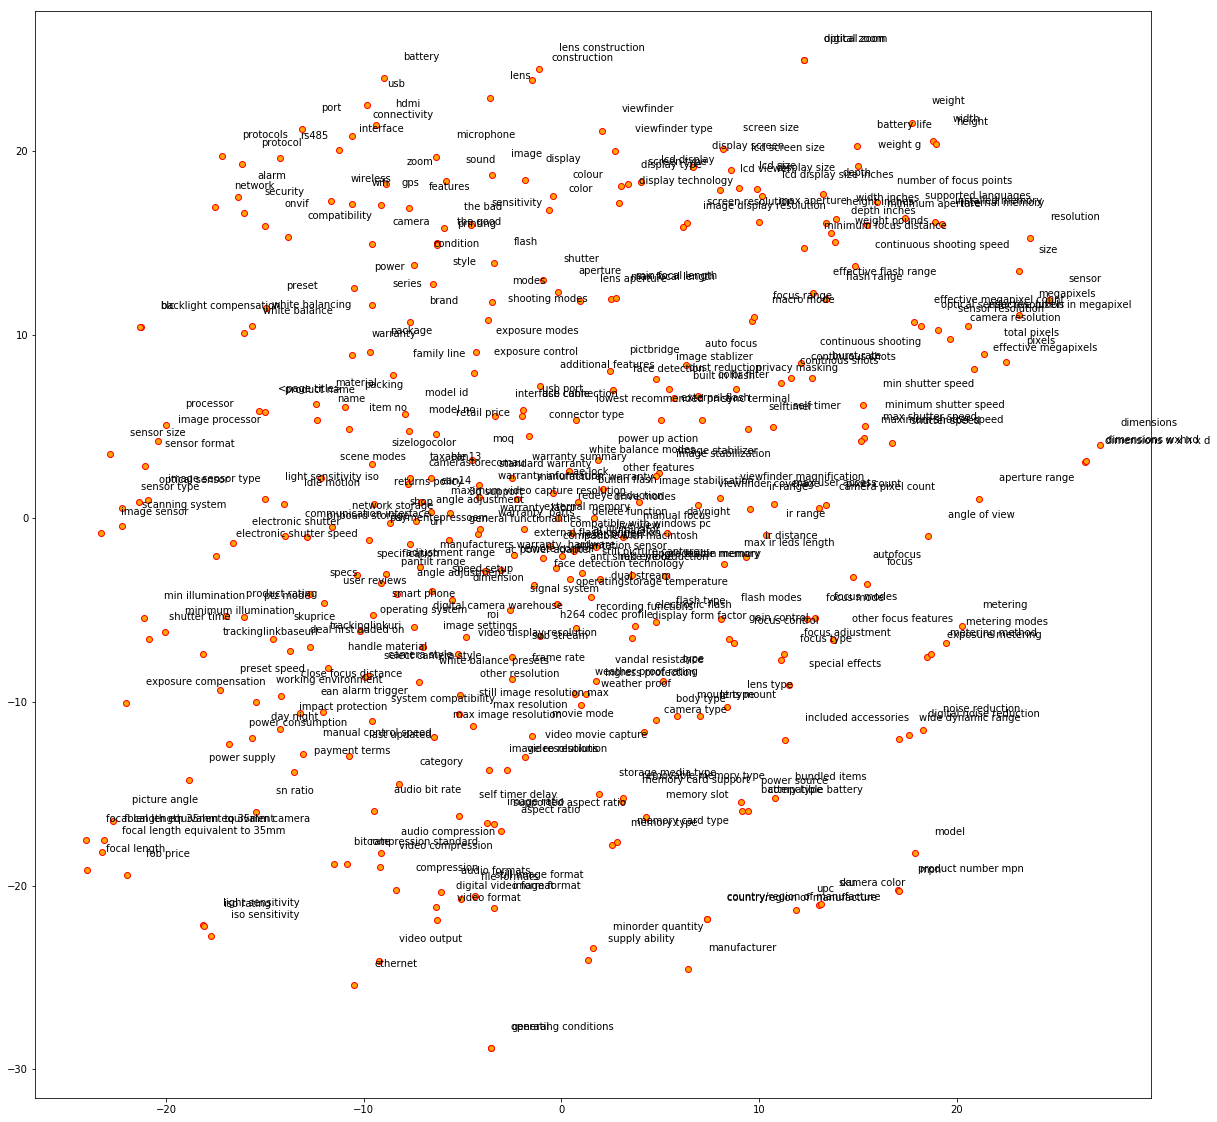

In [22]:
plt.show()

In [23]:
T.shape

(364, 2)

#### KMeans

In [24]:
from nltk.cluster import KMeansClusterer
import nltk
%matplotlib inline

In [25]:
NUM_CLUSTERS=50
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True,repeats=25)
assigned_clusters = kclusterer.cluster(T, assign_clusters=True)

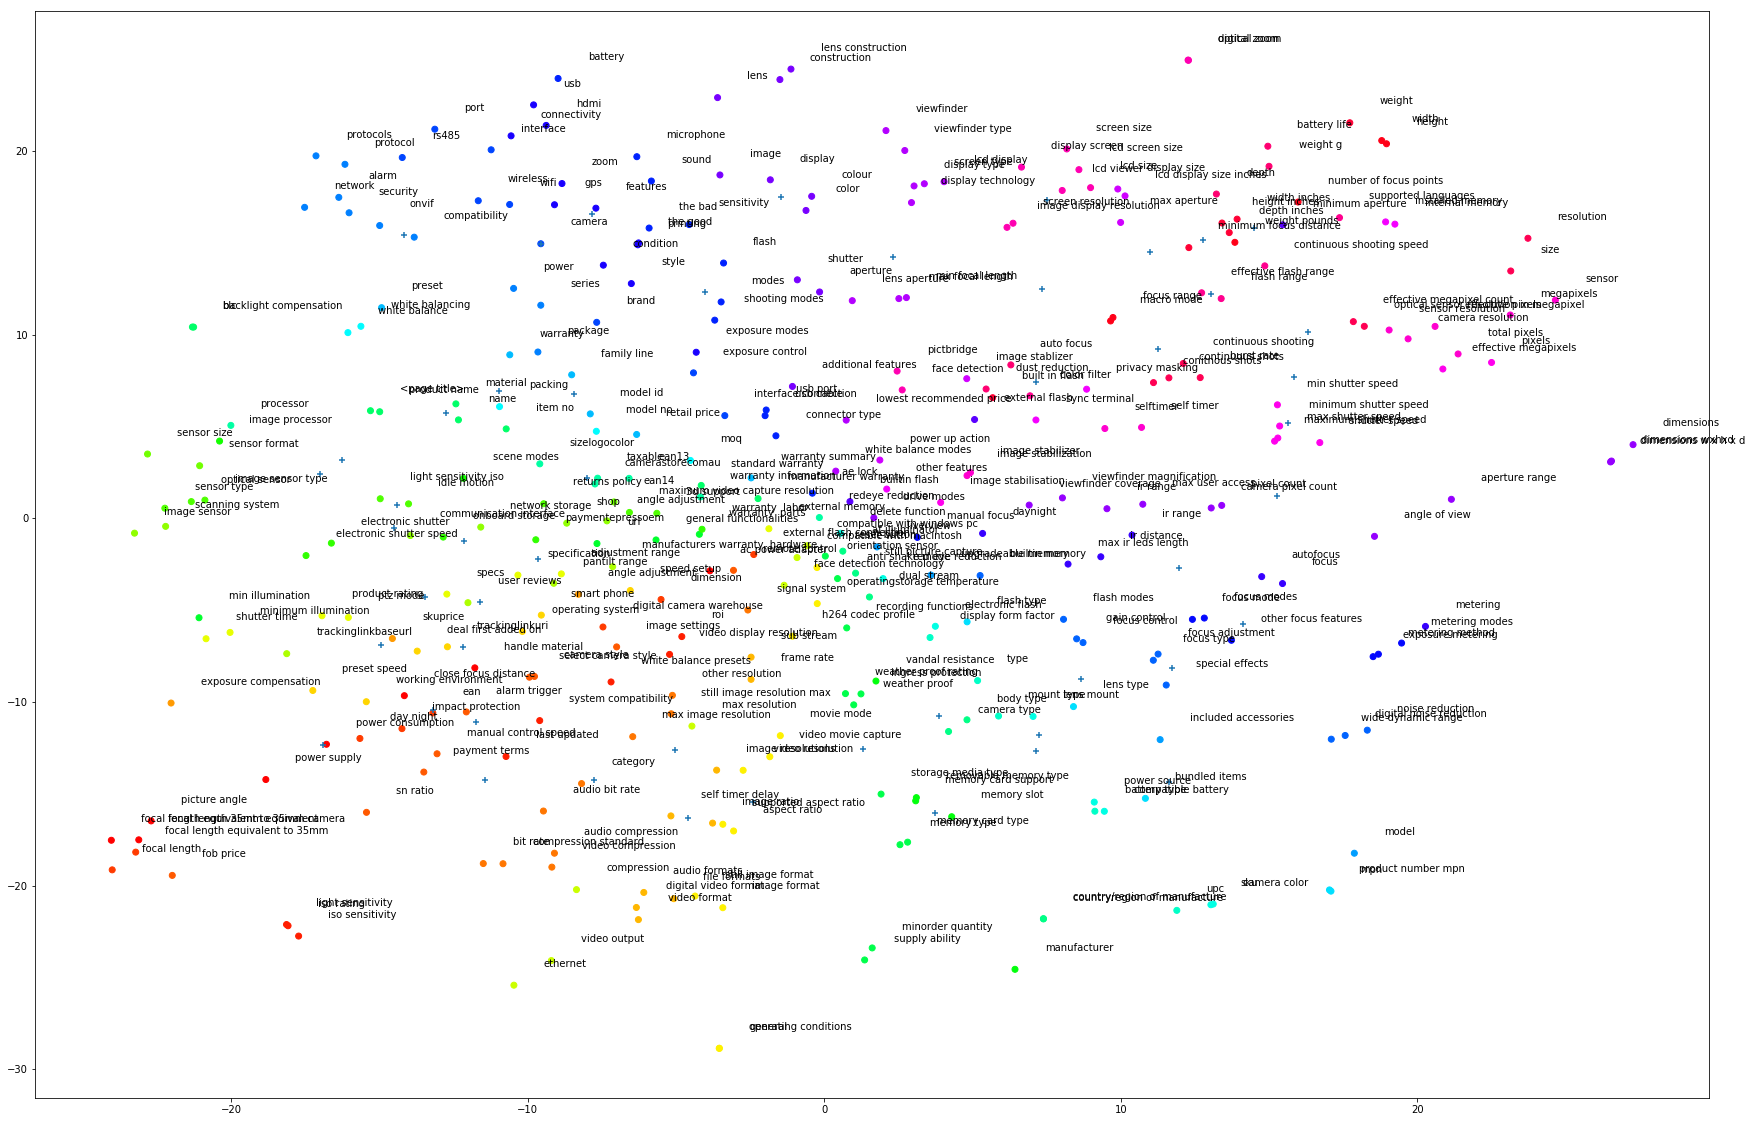

In [26]:
plt.figure(figsize=(30,20))
plt.scatter(T[:,0], T[:,1], c=assigned_clusters, cmap='hsv')
plt.scatter(np.array(kclusterer.means())[:,0], np.array(kclusterer.means())[:,1], marker='+', cmap='hsv')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [27]:
dataset_df,cluster2features = similar_feature_grouping.get_grouped_features(dataset_df,assigned_clusters,labels)

In [28]:
cluster2features

{0: ['power supply',
  'picture angle',
  'ac power adapter',
  'handle material',
  'focal length 35mm equivalent',
  'power consumption',
  'focal length equivalent to 35mm camera',
  'close focus distance'],
 1: ['system compatibility',
  'last updated',
  'iso sensitivity',
  'video display resolution',
  'light sensitivity',
  'roi',
  'iso rating',
  'white balance presets'],
 2: ['external flash connection',
  'ean',
  'focal length',
  'digital camera warehouse',
  'focal length equivalent to 35mm',
  'dimension',
  'day night',
  'impact protection'],
 3: ['alarm trigger',
  'fob price',
  'payment terms',
  'remote control',
  'camera style',
  'image settings',
  'sn ratio',
  'select camera style',
  'manual control speed'],
 4: ['category',
  'bit rate',
  'compression standard',
  'audio bit rate',
  'other resolution',
  'signal system',
  'audio compression',
  'still image resolution max',
  'max image resolution',
  'video compression'],
 5: ['angle adjustment ', 'exp

In [29]:
dataset_df = dataset_df.set_index('spec_id')

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
dataset_df.loc[same_products[1]]

,source,spec_number,page_title,brand,blocking_key,all_features,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
spec_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
www.ebay.com//43645,www.ebay.com,43645,canon eos 5d mark ii body w acc exc used appro...,Canon,[eos],"{'screen size': '3""', 'model': '5d mark', 'meg...",,,,,,,,,,,,,,,,,,,,,canon eos 5d mark body w acc exc used approx 8...,,,013803105384 digital slr,,,2764b003 strap (neck wrist),,5d mark,,,canon,,,,,,,,,,,,21.1 mp,"3""",,,,,
www.ebay.com//54736,www.ebay.com,54736,canon eos 5d mark ii 21 1 mp digital slr camer...,Canon,[eos],"{'model': '5d mark', 'megapixels': '21.1 mp', ...",,,,,,,,,,,,,,,,,,,,,canon eos 5d mark 21 1 mp digital slr camera b...,,,013803105384 digital slr,,,2764b003,,5d mark,,,canon,,,used: item used previously. item may signs cos...,,,,,,,,,21.1 mp,"3""",,,,,
www.gosale.com//1468,www.gosale.com,1468,canon eos 5d mark ii 21.1mp dslr camera on sal...,,[eos],"{'product number mpn': 'eos 5d mark', 'retail ...",,09-october-2014,,,,,,26-august-2009,,,,,,00013803105384,,,,canon,,,canon eos 5d mark 21.1mp dslr camera $2097.93 ...,,0013803105384,013803105384,,,eos 5d mark,$4999.00,,,,,,,,,,,,,,,,21.1 mp,3 inches,,,,,
www.ebay.com//56133,www.ebay.com,56133,canon eos 5d mark ii 21 1 mp digital slr camer...,Canon,[eos],"{'model': '5d mark', 'megapixels': '21.1 mp', ...",,,,,,,,,,,,,,,,,,,,,canon eos 5d mark 21 1 mp digital slr camera b...,,,013803105384 digital slr,,,2764b003,,5d mark,,,canon,,,,,,,,,,,,21.1 mp,"3""",,,,,
www.ebay.com//44639,www.ebay.com,44639,canon eos 5d mark ii 21 1 mp digital slr camer...,Canon,[eos],"{'screen size': '3""', 'model': '5d mark', 'meg...",,,,,,,,,,,,,,,,,,,,,canon eos 5d mark 21 1 mp digital slr camera b...,,,013803105384 digital slr,,,2764b003 strap (neck wrist),,5d mark,,,canon,,,,,,,,,,,,21.1 mp,"3""",,,,,
www.ebay.com//47074,www.ebay.com,47074,canon eos 5d mark ii 21 1 mp digital slr camer...,Canon,[eos],"{'model': '5d mark', 'megapixels': '21.1 mp', ...",,,,,,,,,,,,,,,,,,,,,canon eos 5d mark 21 1 mp digital slr camera e...,,,013803105384 digital slr,,,2764b003,,5d mark,,,canon,,,used: item used previously. item may signs cos...,,,,,,,,,21.1 mp,"3""",,,,,
www.shopmania.in//1643,www.shopmania.in,1643,canon eos 5d mark ii body digital camera price...,Canon,[eos],"{'remote control': 'yes', 'number of focus poi...",,cloudy / daylight / sunny / fine / flash / flu...,"8714574537771, 4960999629490, 8714574529639, 8...",yes,digital cameras,"-/+ 2 ev range, 1/2 1/3 ev steps",2s / 10s 3:2 mov / mpeg / quicktime / wav / h....,,dcf / dpof / jpeg / raw / tiff 640x480 / 1920x...,5 5,,read reviews write review,,36.0x24.0mm full frame,cmos auto / 50 / 100 / 200 / 400 / 800 / 1600 ...,,digic 4,,,detection compactflash,canon eos 5d mark body canon eos 5d mark body ...,body yes dslr,,"fixed 030955241937, 030955242019, 030955242026...",canon ef,automatic / custom / presets,built-in / external,,cable / body cap / carrying strap / charger / ...,,black & white / contrast / fisheye / monochrom...,canon,composite / usb / mini hdmi / mini usb li-ion yes,yes center-weighted / / partial / spot,yes aperture priority / auto / custom / manual...,continuous / contrast detect / detection / liv...,,f/2.8 / f/4.0,98% 0.71x,optical,,,30s (more 65%) 1/8000,optical,"3"" (more 62%) 920000 (more 80%)",3,75 mm,21 mp (more 97%),850 g,9 114 mm 152 mm
www.ebay.com//54794,www.ebay.com,54794,canon eos 5d mark ii 21 1 mp digital slr 4 len...,Canon,[eos],"{'screen size': '3""', 'model': '5d mark', 'meg...",,,,,,,,,,,,,,,,,,,,,canon eos 5d mark 21 1 mp digital slr 4 lenses...,,,013803105384 digital slr,,,"2764b003 case bag, extra battery, extra batter...",,5d mark,,,canon,,,used: item used previously. item may signs cos...,,,,,,,,,21.1 mp,"3""",,,,,
www.ebay.com//45742,www.ebay.com,45742,canon 5d markii body only not working mark ii ...,Canon,[canon],"{'model': '5d mark

# FOR A SINGLE BLOCK - Nikon

In [31]:
dataset_df.head(50)
dataset_df = dataset_df.explode('blocking_key')
grouped_df = dataset_df.groupby(['blocking_key'])

In [1453]:
[(key,value) for key,value in grouped_df.size().items() if value>1000]

[('coolpix', 1963),
 ('eos', 2441),
 ('fujifilm', 1555),
 ('hikvision', 1961),
 ('nikon', 2856),
 ('olympus', 1457),
 ('other', 4849),
 ('panasonic', 1321),
 ('powershot', 2272),
 ('samsung', 1083),
 ('sony', 2685)]

In [1454]:
blocking_key="panasonic"
block_df = grouped_df.get_group(blocking_key)

In [1455]:
len(set(dataset_df['blocking_key']))

86

In [1456]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
block_df

,source,spec_number,page_title,brand,blocking_key,all_features,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
spec_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
buy.net//4310,buy.net,4310,panasonic i-pro smarthd wvst162 network camera...,,panasonic,"{'analog video out': 'yes', 'focal length': '1...",,,1.95 mm,,,,,,,,,,mos,,800 x 600,,,,http://www.panasonic.com,,panasonic i-pro smarthd wvst162 network camera...,surveillance/network camera,,,,,,,,,,,,,,,,,,auto,,,,,8x,,2.9,,12.17 oz,3.9 3.9
buy.net//5455,buy.net,5455,panasonic lumix dmc-xs1 16.1 megapixel compact...,,panasonic,"{'wide angle': 'yes', 'battery builtin': '', '...",24 mm 120 mm 24 mm 120 mm,iso 6400,4.30 mm 21.50 mm,,,,,,,,,,ccd,,1280 x 720,,,microsd card|microsdhc card|secure digital (sd...,http://www.panasonic.com,,panasonic lumix dmc-xs1 16.1 megapixel compact...,compact camera,1 year,,,,,,,,,program ae,red-eye fix|red-eye reduction|auto flash|flash...,,,,yes,6 elements 5 groups,,autodaylightcloudyshadeincandescentwhite set,,,16.1 megapixel,16600000 optical,4x 2.7 yes 5 x,,0.7,,3.10 oz,3.7 2.1
buy.net//5475,buy.net,5475,panasonic lumix dmc-zs40 black digital camera ...,,panasonic,"{'focal length': '4.3 mm 129mm', 'wifi': 'yes'...",24 mm 720mm,,4.3 mm 129mm,,,,,,,,,,cmos,,1920 x 1080,,,secure digital high capacity (sdhc) card|secur...,http://shop.panasonic.com/shop/model/dmc-zs40k,,panasonic lumix dmc-zs40 black digital camera ...,point & shoot digital camera,1 year(s),,,,,,,,,yes usb,built-in flash,,,,,,,,3.3 1/f,12 mb,"18,100,000 pixels","18,900,000 pixels optical",3 4 x 30 x,,1.35,,0.47 lbs,4.35 2.53
buy.net//5645,buy.net,5645,panasonic lumix dmc-zs40 black digital camera ...,,panasonic,"{'focal length': '4.3 mm 129 mm', 'wifi': 'yes...",24 mm 720 mm,,4.3 mm 129 mm,,,,,,,,,,cmos,,1920 x 1080,,,secure digital (sd) card|secure digital extend...,http://shop.panasonic.com/shop/model/dmc-zs40k,,panasonic lumix dmc-zs40 black digital camera ...,point & shoot digital camera,1 year(s),,,,,,,,,yes usb,built-in flash,,,,,,,,3.3 1/f,12 mb,18100000 pixels,18900000 pixels,3 4 x 30 x,,1.35,,0.47 lbs,4.35 2.53
buy.net//5666,buy.net,5666,panasonic lumix dmc-lf1 white digital camera (...,,panasonic,"{'focal length': '6 mm 42.80 mm', 'wifi': 'yes...",28 mm 200 mm,,6 mm 42.80 mm,,,,,,,,,,mos,,1920 x 1080,,,secure digital (sd) card|secure digital extend...,http://www.panasonic.com,,panasonic lumix dmc-lf1 white digital camera (...,bridge camera,1 year,,,,,,,,,yes usb,auto flash|flash on|flash off|red-eye reductio...,,,,,,,,2 1/f,87 mb,12.1 megapixel,12800000 optical,3 4x 7.1 x,,1.1,,6.00 oz,4.0 2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
www.wexphotographic.com//607,www.wexphotographic.com,607,panasonic lumix dmc-sz8 digital camera - black...,,panasonic,"{'battery model': 'dwm-bcl7', 'an': 'image inc...",,,,,,,"jpeg, quicktime motion jpeg",,720p,,yes,,,1/2.33 inch,ccd,,,,,,panasonic lumix dmc-sz8 digital camera - black...,,,,,,built-in,,,,,"1/3 ev step, +/-2 ev",,,"output (pal / ntsc), usb (av/usb multi) 30 sce...",,,black,,lcd,,,yes,16.0,yes,,144,99.8 x 60.4 x 26.5 mm 4608 x 3456,,
www.wexphotographic.com//608,www.wexphotographic.com,608,panasonic lumix dmc-tz55 digital camera - blac...,,panasonic,"{'battery model': 'dmw-bcm13', 'an': 'image in...",,,,,,,"jpeg, mp4",,1080p,,yes,,,1/2.33 inch,mos,,,,,,panasonic lumix dmc-tz55 digital camera - blac...,,,,,,built-in,,,,,"1/3 ev step, +/-2 ev",,,"microhdmi, output (pal / ntsc), usb (av/usb mu...",,,black,,lcd,,,yes,16.0,yes,,224,106.8 x 62.2 x 32.4 mm 4608 x 3456,3cm,
www.wexphotographic.com//614,www.wexphotographic.com,614,panasonic lumix dmc-lx100 digital camera - bla...,,panasonic,"{'an': 'image incorrect', 'focal length wide':...",,,,,,,,,4k

## CLUSTERING INSIDE BLOCK

In [1458]:
#concatanate new features
block_df['concat_text']=''
for i in range(NUM_CLUSTERS):
    block_df['concat_text']+=block_df[i]+' '
block_df['concat_text'] = block_df['concat_text'].apply(lambda x: x.replace('  ',' '))

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [1459]:
def get_avg_vector(x,brand):
    avg=np.zeros((200,))
    x=x.replace(brand,'')
    x=x.replace('  ',' ')
    words = x.split() 
    model_vec=model.wv[brand]
    if len(words)>1 and words[0] in model.wv: 
        model_vec= model.wv[words[0]] 
    for i in range(len(words[1:])):
        word=words[i]
        if word in model.wv:
            avg += model.wv[word]  
    if len(words)>0:
        avg= avg/(len(words))
    return np.concatenate((model_vec,avg))

In [1460]:
block_df['concat_wordvector']=''
for index, row in block_df.iterrows():
    x=row['page_title']
    block_df.at[index,'concat_wordvector']=get_avg_vector(\
        ' '.join([' '.join(x[idx:].split()[:3]) for idx in [x.start() for x in re.finditer(blocking_key, x)]] + [' '.join(sigmod.extract_model_words(token)) for token in list(everygrams(x.split(),2,3))]),blocking_key)                                                                                                                                                     

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [1461]:
X=np.zeros((len(block_df),400))
for i in range(len(block_df)):
    X[i]=block_df['concat_wordvector'][i]

In [1462]:
# visualize embeddings
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=20)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(X)
labels = block_df['spec_number'].values

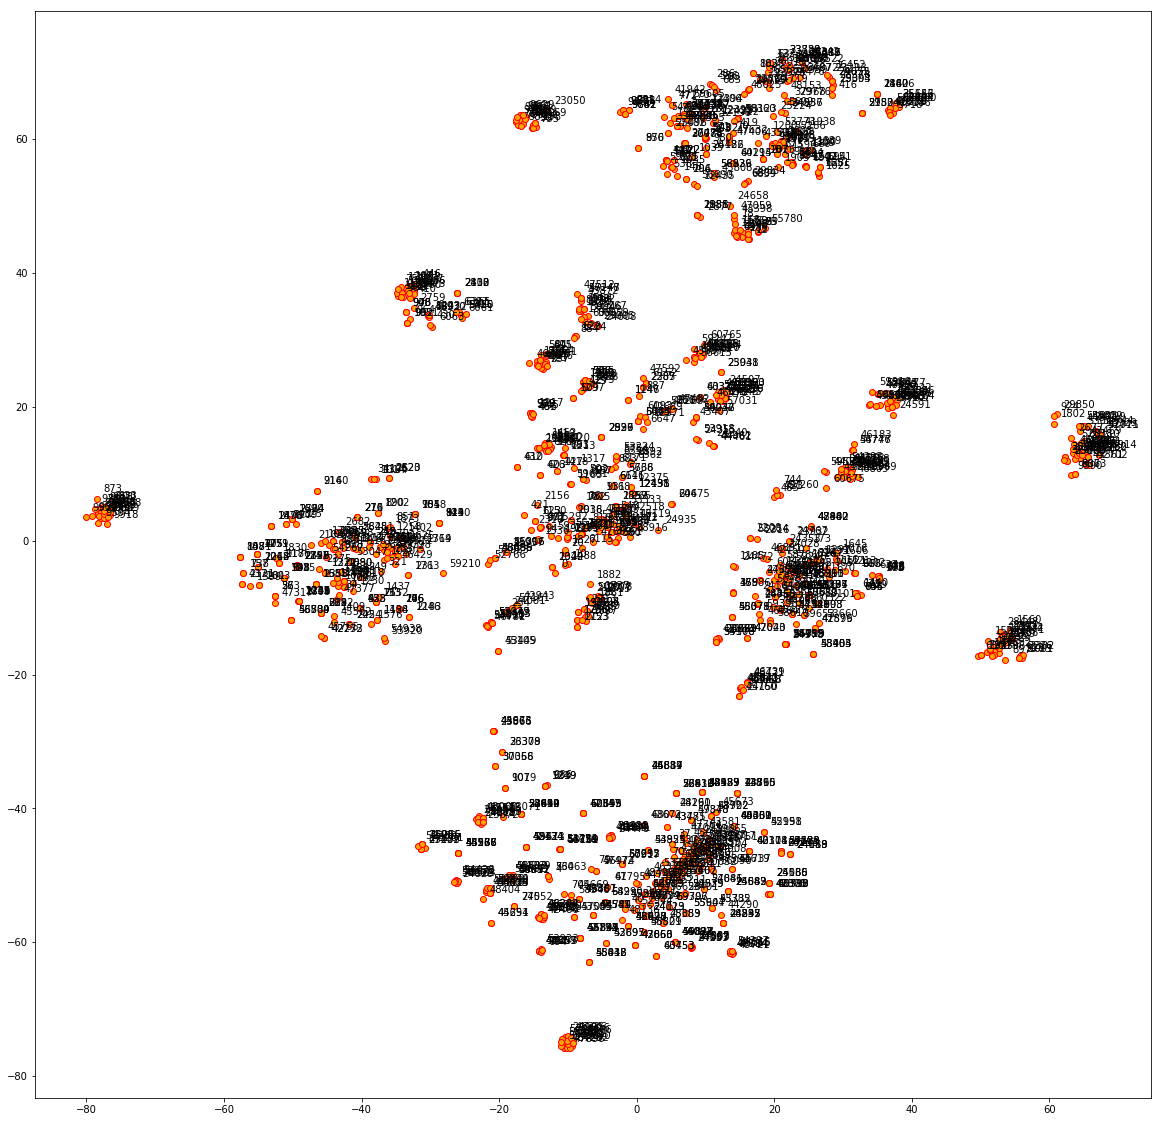

In [1463]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [1464]:
plt.show()

In [1465]:
T.shape

(1321, 2)

#### KMeans

In [1466]:
from nltk.cluster import KMeansClusterer
import nltk
%matplotlib inline

In [1467]:
from sklearn.cluster import KMeans
import numpy as np
kclusterer = KMeans(n_clusters=5, random_state=0).fit(T)
assigned_clusters = kclusterer.labels_

In [1468]:
from sklearn.cluster import DBSCAN
import numpy as np
kclusterer = DBSCAN(eps=0.2, min_samples=1).fit(T)
assigned_clusters = kclusterer.labels_

In [1469]:
set(assigned_clusters)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


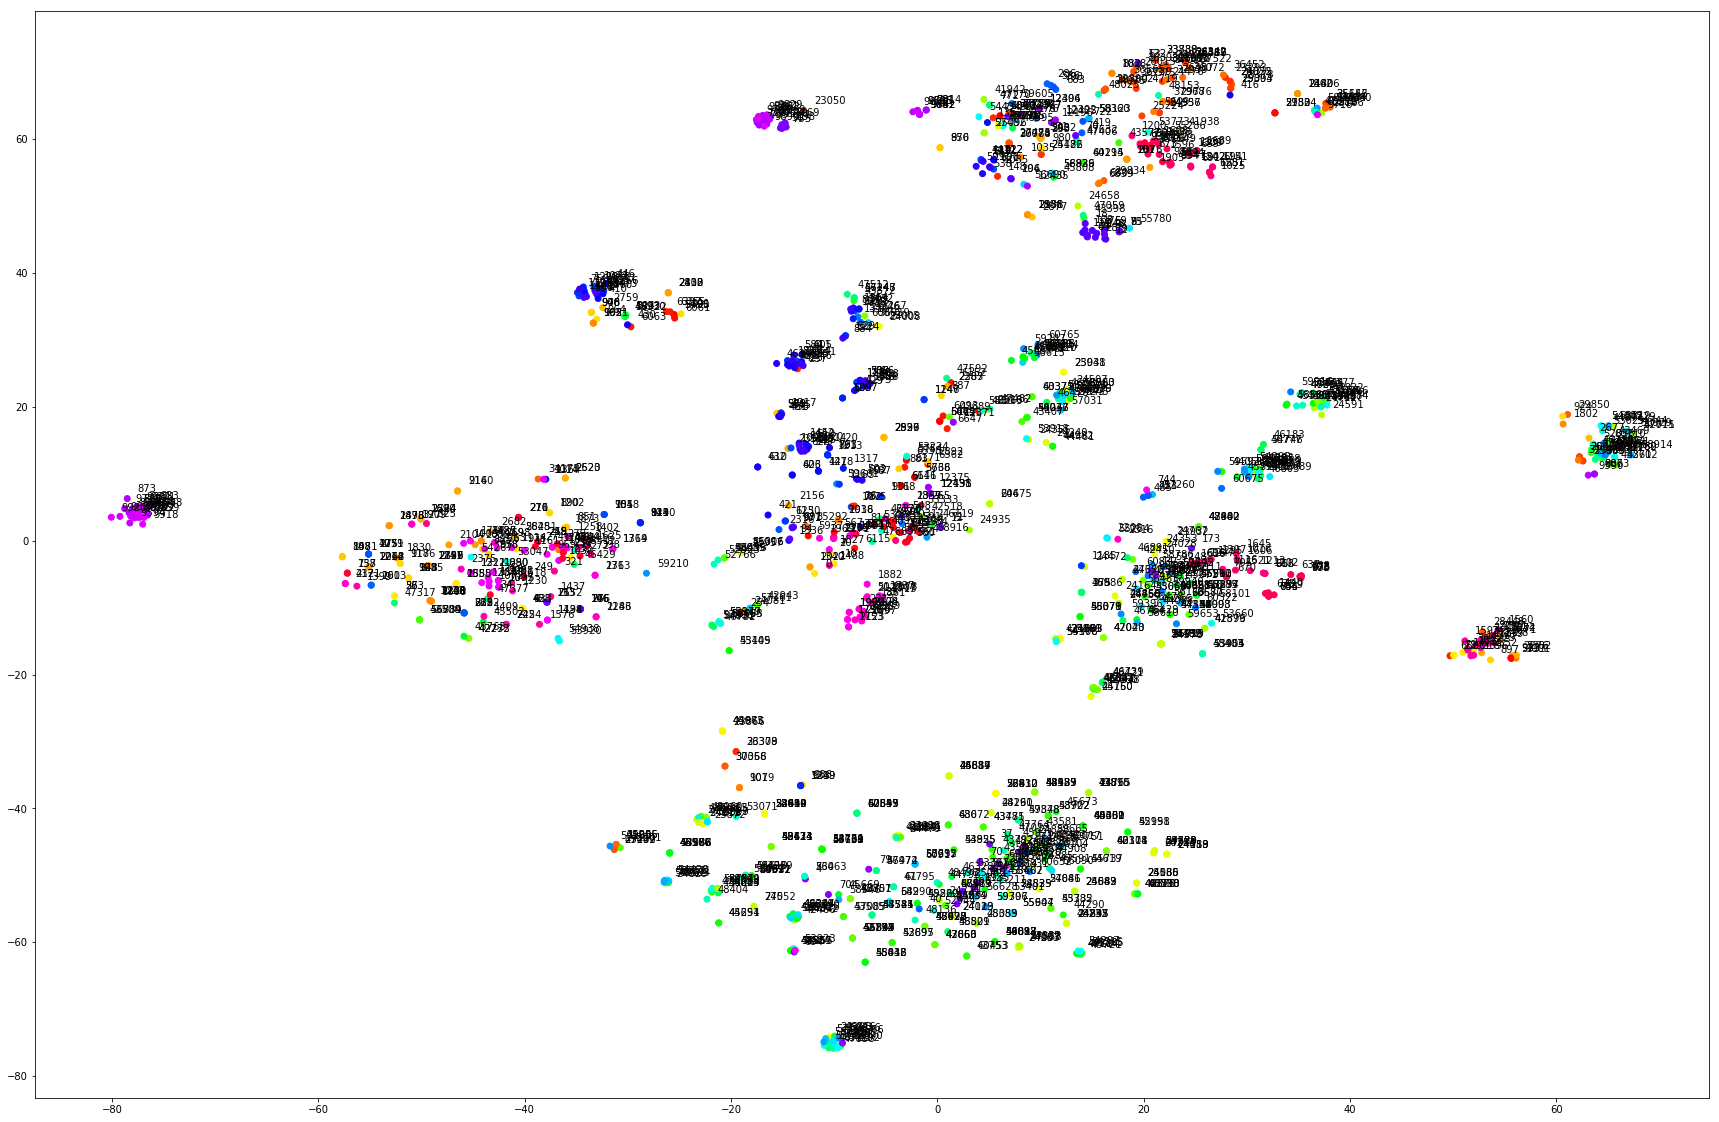

In [1470]:
plt.figure(figsize=(30,20))
plt.scatter(T[:,0], T[:,1], c=assigned_clusters, cmap='hsv')

for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [1471]:
block_df['inblock_cluster'] = assigned_clusters

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [1472]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 3000
block_group_df = block_df.groupby('inblock_cluster')

In [1473]:
for i in range(len(list(set(assigned_clusters)))):
    if(len(block_group_df.get_group(i)[['page_title']])>1):
        print(block_group_df.get_group(i)[['page_title']].values)
        print('-------------------')
        

[['panasonic i-pro smarthd wvst162 network camera - color, monochrome (mos - cable - fast ethernet) price comparison at buy.net']
 ['panasonic i-pro smarthd wv-st165 network camera - color, monochrome (mos - cable - fast ethernet) price comparison at buy.net']]
-------------------
[['panasonic lumix dmc-xs1 16.1 megapixel compact camera - red (2.7" lcd - 5x optical zoom - optical is - 4608 x 3456 image - 1280 x 720 video - pictbridge - hd movie mode) price comparison at buy.net']
 ['panasonic lumix dmc-xs1 16.1 megapixel compact camera - white (2.7" lcd - 5x optical zoom - optical is - 4608 x 3456 image - 1280 x 720 video - pictbridge - hd movie mode) price comparison at buy.net']]
-------------------
[['panasonic lumix dmc-zs40 black digital camera (18.1 mp, 30x opt, sd/sdhc/sdxc card slot) price comparison at buy.net']
 ['panasonic lumix dmc-zs40 black digital camera (18.1 mp, 30x opt, sd/sdhc/sdxc card slot, 12 mb) price comparison at buy.net']
 ['panasonic lumix dmc-zs40 silver dig

-------------------
[['retail waterproof camera bag +swim accessory in water sports - buy swim accessory,digital camera silicone case,camera case for panasonic lumix product on alibaba.com']
 ['panasonic lumix 14 1 megapixels | ebay']
 ['panasonic lumix dmc fx 80 price in india with offers & full specifications | pricedekho.com']]
-------------------
[['china cctv manufacturer supply original panasonic ccd 800tvl white light cctv camera - buy camera,800tvl white light cctv camera,white light cctv camera product on alibaba.com']
 ['china professional manufacturer supply new design color night vision panasonic ccd white light surveillance camera - buy surveillance camera,white light surveillance camera,ccd surveillance camera product on alibaba.com']]
-------------------
[['(not provided) | panasonic lumix dmc-gh2 digital camera w/14-140mm lens (black) reviews - buzzillions.com']
 ['panasonic lumix dmc-gh2 digital camera w/14-42mm lens (silver) reviews | buzzillions.com']]
--------------

 ['panasonic lumix dmc fx700 14 1 mp digital camera black 5025232579709 | ebay']]
-------------------
[['panasonic lumix dmc f3 12 1 mp digital camera black | ebay']
 ['panasonic lumix dmc f3 price in india, bangalore, hyderabad, delhi, chennai, mumbai, pune, kolkatta']]
-------------------
[['panasonic lumix dmc lz5 6 0 mp digital camera silver | ebay']
 ['panasonic lumix dmc lz5 | ebay']
 ['panasonic lumix dmc lz5 6 0 mp digital camera silver | ebay']]
-------------------
[['panasonic lumix lc1 5mp digital camera in original box shutter count 741 | ebay']
 ['panasonic lumix dmc-fx7k 5mp digital on sale for $398.45']]
-------------------
[['panasonic lumix dmc zr1 dmc zx1 12 1 mp digital camera silver no reserve 0037988263707 | ebay']
 ['panasonic lumix dmc zr1 dmc zx1 12 1 mp digital camera black with accessories | ebay']]
-------------------
[['ã\x80\x90newã\x80\x91 panasonic lumix dmc tz40 dmc zs30 18 1 mp digital camera from japan 017852009594 | ebay']
 ['panasonic lumix dmc zs30 

[['panasonic lumix dmc tz3 digital camera with 10x zoom | ebay']
 ['panasonic lumix dmc tz3 digital camera with 10x zoom | ebay']]
-------------------
[['panasonic lumix dmc zs25 16 1mp 20x zoom black read description before bidding 689466657111 | ebay']
 ['panasonic lumix dmc zs25 digital camera 16 1mp 20x bundle memory card strap case 689466657111 | ebay']]
-------------------
[['panasonic lumix dmc gh2 16 0 mp digital camera black body only 5025232591343 | ebay']
 ['panasonic lumix dmc gh2 16 0 mp digital camera black body only accessories 5025232591343 | ebay']
 ['panasonic lumix dmc gh2 16 0 mp digital camera black body only 5025232591343 | ebay']]
-------------------
[['panasonic lumix dmc gh4 4k video hd wi fi micro four thirds digital camera body | ebay']
 ['panasonic lumix dmc gh4 4k video hd wi fi micro four thirds digital camera body | ebay']
 ['panasonic lumix dmc gh4 mft 4k video mirrorless camera body w factory warranty 5025232701612 | ebay']]
-------------------
[['panas

In [ ]:
NUM_CLUSTERS=50
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True,repeats=25)
assigned_clusters = kclusterer.cluster(T, assign_clusters=True)

*****

In [81]:
global counter
counter=0
block_df['page_title_sim']=""

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [82]:
def get_sim_among_col(x,column_data):
    sim_array=np.zeros(len(column_data))
    i=0
    global counter
    for cell_data in column_data.values:
        sim_array[i]=helper.cosine_sim(helper.text_to_ngrams(x,3,'chars'),helper.text_to_ngrams(cell_data,3,'chars'))
        i+=1
    counter+=1
    if(counter%10==0):
        print(counter/len(column_data),np.mean(sim_array))
    return sim_array

In [83]:
block_df['page_title']=block_df['page_title'].apply(lambda x: x.replace(blocking_key,''))
block_df['page_title_sim']=block_df['page_title'].apply(lambda x: get_sim_among_col(x,block_df['page_title']))

/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0.08064516129032258 0.422938771891194
0.16129032258064516 0.3674895169302204
0.24193548387096775 0.409310116926526
0.3225806451612903 0.30396600829878434
0.4032258064516129 0.2824573862786402
0.4838709677419355 0.36076282086919215
0.5645161290322581 0.3483672865675565
0.6451612903225806 0.3674895169302204
0.7258064516129032 0.33544724891428646
0.8064516129032258 0.3426596694304323
0.8870967741935484 0.1749913556068736
0.967741935483871 0.04627118683594261


/Users/gunesyurdakul/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [84]:
block_df

,source,spec_number,page_title,brand,blocking_key,all_features,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,page_title_sim
spec_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
buy.net//4236,buy.net,4236,is426 16 megapixel compact camera - red - 2.4...,,polaroid,"{'brand name': 'Polaroid', 'minimum diopter ad...",,,,,,,,,,polaroid is426 16 megapixel compact camera - r...,no,,,,,,,,,,auto,,,,,,,,,,yes,,,,,,,,yes,,,,,,,,,,,,"[1.0, 0.38320785823842407, 0.3272787379567186,..."
buy.net//5388,buy.net,5388,"z2300 black digital camera (10 mp, 1x opt, sd...",,polaroid,"{'flash': 'Built-in Flash', 'image sensor': 'C...",,cmos,4.75 in 3.06 in,9.31 oz 1.5 in,1 x 2.4 x,,32 mb,,10000000 pixels,"polaroid z2300 black digital camera (10 mp, 1x...",,2.5 in,point & shoot digital camera,,,,,1280 x 720,,1 year(s),,,,,,,,built-in flash,,,,http://www.polaroidstore.com/products/instant-...,,,,,,secure digital (sd) card|secure digital high c...,,usb,,,,,,,,,,,"[0.38320785823842407, 1.0, 0.6381308867560208,..."
buy.net//5865,buy.net,5865,z340 instant digital camera w/ universal adap...,,polaroid,"{'depth': '6.1 in', 'camera body only': 'Yes',...",,,2.6 in 5 in,6.1 in 1.37 lbs,5 x,,,,,polaroid z340 instant digital camera w/ univer...,,,,,,,,,,1 year(s),,,,,,,,flash cancel (on/off)|built-in flash|automatic...,,,,http://www.polaroidstore.com/store/products/in...,,,,,,,,,,,,,,,,,,,"[0.3272787379567186, 0.6381308867560208, 1.0, ..."
buy.net//6044,buy.net,6044,"is326 16 megapixel compact camera - red (2.4""...",,polaroid,"{'flash': 'Built-in Flash', 'image sensor': 'C...",,cmos,,,3 x 4x,6.20 mm to 12.40 mm,,,16 megapixel,polaroid is326 16 megapixel compact camera - r...,,2.4 in,compact camera,,,,,1280 x 720,,1 year(s),,,,,,,,built-in flash,,,,http://www.polaroid.com/us/,,,,electronic,,secure digital (sd) card,,usb,,,,,,,,,,,"[0.6609973383045787, 0.33909432367707615, 0.28..."
www.alibaba.com//29701,www.alibaba.com,29701,720p 1.0mp / 960p 1.3mp ahd waterproof camera ...,,polaroid,{'fob price': 'US $15 - 21 / Set Get Latest Pr...,,,,,,us $15 - 21 / set get latest\nprice,,,,1 set/sets 5000 piece/pieces per month 720p 1....,,,,,,,,,,,,,,,"l/c,d/a,d/p,t/t,western union,moneygram,paypal",,,,,,,,,,,,,,,shenzhen,,,,,,,,,,,"[0.10778636357219332, 0.22329794843441186, 0.1..."
www.buzzillions.com//1028,www.buzzillions.com,1028,z340 3x4 instant digital camera + review | z...,,polaroid,"{'compatible with windows pc': 'Yes', 'specifi...",,,,,4x 4x,,,,0081536101567 14,polaroid z340 3x4 instant digital camera + rev...,,2.7 inch,point & shoot with fixed lens,,,included,,,,,,description 1 year,,ccd,,,built-in,,,,,,yes,,,,,,,,,yes,,,,,,secure digital (sd),,,"[0.1086610735988866, 0.20430156738209967, 0.32..."
www.buzzillions.com//1974,www.buzzillions.com,1974,is326 digital camera (white) reviews | buzzil...,,polaroid,"{'specification': 'Description', 'style': 'IS3...",,,,,,,,,16 megapixels,polaroid is326 digital camera (white) reviews ...,289315 white,,point & shoot with zoom lens,,,,,,,,,description,,white,,,,,,http://www.meijer.com,,/catalog/ 69.9900,,,,,,,,,,,,is326whrd,,,,,,,"[0.0827379240401869, 0.21778620259218834, 0.23..."
www.buzzillions.com//2081,www.buzzillions.com,2081,10 megapixel touchscreen digital camera revie...,,polaroid,"{'specification': 'Description', 'sku': '17177...",,,,,,,,,,polaroid 10 megapixel touchscreen digital came...,171776,,,,,,,,,,,description,,,,,,,,"['http://www.meijer.com', 'http://www.beachaud...",,['/product_info.php?products_id=341976&src=pwr...,,,,,,,,,,,,cta01035s,,,,,,,"[0.20535012709710015, 0.20913407192853073, 0.1..."
www.buzzillions.com//950,www.buzzillions.com,950,camera 1437tc mp reviews | cia-1437tc 14 meg...,,polaroid,"{'camera pixel count': '14 Megapixel', 'resolu...",,,"2.7""",,"['5x', '4x'] 3x",,64 mb,16mb,14 cia1437tc,polaroid camera 1437tc mp reviews | polaroid c...,"['titanium', 'silver / gray']",2.7 inch,,,auto vga - up t

In [85]:
cluster2features

{0: ['minimum aperture',
  'continuous shooting speed',
  'battery life',
  'number of focus points'],
 1: ['weight g',
  'image sensor',
  'weight pounds',
  'width inches',
  'height inches',
  'depth inches'],
 2: ['display screen',
  'max aperture',
  'height',
  'size',
  'display size',
  'lcd size',
  'sensor type',
  'width'],
 3: ['lcd display size inches',
  'depth',
  'screen resolution',
  'dimension',
  'weight',
  'minimum focus distance',
  'image display resolution',
  'scanning system'],
 4: ['digital zoom',
  'optical zoom',
  'product number mpn',
  'viewfinder magnification'],
 5: ['display technology',
  'picture angle',
  'focal length 35mm equivalent',
  'lcd display',
  'fob price',
  'aperture range',
  'screen type',
  'image processor',
  'min focal length',
  'frame rate',
  'focal length equivalent to 35mm',
  'focal length',
  'display type',
  'focal length equivalent to 35mm camera',
  'max focal length'],
 6: ['installed memory',
  'effective flash rang

In [87]:
block_df.iloc[np.argsort(-block_df['page_title_sim'].loc['www.ebay.com//55234'])]

,source,spec_number,page_title,brand,blocking_key,all_features,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,page_title_sim
spec_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
www.ebay.com//55234,www.ebay.com,55234,i633 6 0 mp digital camera works great plus c...,Polaroid,polaroid,"{'mpn': 'I633', 'screen size': '2.4""', 'bundle...",,,,,3x,,,i633,i633 6.0 mp,polaroid i633 6 0 mp digital camera works grea...,point & shoot,"2.4""",,826219009180,,,,,,,,,,,,,,,,,,,strap (neck or wrist),,,,,,,,used: an item that has been used previously. t...,,,polaroid,,,,,,,"[0.05247735352883857, 0.20144406207413396, 0.1..."
www.ebay.com//58686,www.ebay.com,58686,digital camera i633 works 826219009180 | ebay,Polaroid,polaroid,"{'mpn': 'I633', 'screen size': '2.4""', 'megapi...",,,,,3x,,,i633,6.0 mp i633,polaroid digital camera i633 works 82621900918...,point & shoot,"2.4""",,826219009180,,,,,,,,,,,,,,,,,,,,,,,,,,,used: an item that has been used previously. t...,,,polaroid,,,,,,,"[0.07122445697957626, 0.21482080588773944, 0.1..."
www.ebay.com//52868,www.ebay.com,52868,digital camera i633 with tripod and rca usb c...,Polaroid,polaroid,"{'mpn': 'I633', 'screen size': '2.4""', 'bundle...",,,,,3x,,,i633,6.0 mp i633,polaroid digital camera i633 with tripod and r...,point & shoot,"2.4""",,826219009180,,,,,,,,,,,,,,,,,,,"case or bag, memory card, tripod",,,,,,,,used: an item that has been used previously. t...,,,polaroid,,no,,,,,"[0.05445832342080846, 0.1941163553652547, 0.17..."
www.ebay.com//44347,www.ebay.com,44347,digital camera i633 with tripod and rca usb c...,Polaroid,polaroid,"{'mpn': 'I633', 'screen size': '2.4""', 'bundle...",,,,,3x,,,i633,6.0 mp i633,polaroid digital camera i633 with tripod and r...,point & shoot,"2.4""",,826219009180,,,,,,,,,,,,,,,,,,,"case or bag, memory card, tripod",,,,,,,,used: an item that has been used previously. t...,,,polaroid,,no,,,,,"[0.05445832342080846, 0.1941163553652547, 0.17..."
www.ebay.com//45275,www.ebay.com,45275,i631 6 0 mp digital camera pink 0826219009883...,Polaroid,polaroid,"{'type': 'Light Field Camera', 'bundled items'...",,,,,3x,,,,i631 6.0 mp,polaroid i631 6 0 mp digital camera pink 08262...,light field camera,,,,,,,,,,,,,,,,,,,,,,"case or bag, strap (neck or wrist)",,,,,,,,used: an item that has been used previously. t...,,,polaroid,,,,,,,"[0.08468496511259617, 0.22291128503014113, 0.1..."
www.ebay.com//44919,www.ebay.com,44919,i834 8 0 mp digital camera purple 82621900989...,Polaroid,polaroid,"{'mpn': 'I834PRPL', 'screen size': '3""', 'mega...",,,,,3x,,,i834prpl,8.0 mp i834,polaroid i834 8 0 mp digital camera purple 826...,point & shoot,"3""",,826219009890,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,polaroid,,,,,,,"[0.0669555708881764, 0.22030404580620944, 0.18..."
www.ebay.com//55438,www.ebay.com,55438,i834 8 0 mp digital camera purple 82621900989...,Polaroid,polaroid,"{'mpn': 'I834PRPL', 'screen size': '3""', 'mega...",,,,,3x,,,i834prpl,8.0 mp i834,polaroid i834 8 0 mp digital camera purple 826...,point & shoot,"3""",,826219009890,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,polaroid,,,,,,,"[0.0669555708881764, 0.22030404580620944, 0.18..."
www.ebay.com//24782,www.ebay.com,24782,i733 7 0 mp digital camera pink 826219009807 ...,Polaroid,polaroid,"{'mpn': 'i733', 'screen size': '2.5""', 'megapi...",,,,,3x,,,i733,7.0 mp i733,polaroid i733 7 0 mp digital camera pink 82621...,point & shoot,"2.5""",,826219009807,,,,,,,,,,,,,,,,,,,,,,,,,,,for parts or not working: an item that does no...,,,polaroid,,,,,,,"[0.08571148701754475, 0.2256133386548836, 0.18..."
www.ebay.com//53166,www.ebay.com,53166,i733 7 0 mp digital camera pink 826219009807 ...,Polaroid,polaroid,"{'mpn': 'i733', 'screen size': '2.5""', 'megapi...",,,,,3x,,,i733,7.0 mp i733,polaroid i733 7 0 mp digital camera pink 82621...,point & shoot,"2.5""",,826219009807,,,,,,,,,,,,,,,,,,,,,,,,,,,for parts or not working: an item that does no...,,,polaroid,,,,,,,"[0.08571148

In [ ]:
block_df.iloc[0]['page_title']

In [ ]:
sigmod.extract_model_words(['hero 3','dfgh','we','16 mp'])

In [ ]:
helper.cosine_sim(n1,n2)

In [ ]:
for idx in range(NUM_CLUSTERS):
    dataset_df[idx]=dataset_df[idx].apply(lambda x: )

In [ ]:
'nikon sauask akska nikon sdsds'.replace('nikon','')

In [ ]:
for i in range(len)